In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=10000)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

from tensorflow import keras
from tifffile import imsave, imread, imwrite
from keras.models import Input, Model
from keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,LearningRateScheduler
from tifffile import imwrite

from datagenerator_3D import stack_generator, data_generator
# from model_3D_interconnect import make_generator
from model_3D import make_generator
from loss_3D import generator_loss

1 Physical GPUs, 1 Logical GPUs


In [2]:
frame_start =  0
frame_end =  8
patch_size =  160
n_patches =  1
n_channel =  0
augment = False 
shuffle = True 
batch_size = 1

GT_image_dr = r'D:\Projects\Denosing-STED-Abberior\2022-11-03_UCF_DemoSamples\3D STED_TOM20\patches\Average'
lowSNR_image_dr =r'D:\Projects\Denosing-STED-Abberior\2022-11-03_UCF_DemoSamples\3D STED_TOM20\patches\1frame'


gt,low=stack_generator(GT_image_dr,lowSNR_image_dr, fr_start=frame_start,fr_end=frame_end)

x_train, y_train, x_valid, y_valid = data_generator(gt, low, patch_size, n_patches, n_channel, 
                                                    threshold=0, ratio=1.0,
                                                    fr_start=frame_start, fr_end=frame_end
                                                    ,augment=augment, shuffle=shuffle)

(976, 8, 1, 160, 160)
(976, 160, 160, 8, 1)
976
The training set shape is: (976, 160, 160, 8, 1)
The validation set shape is: (0, 160, 160, 8, 1)


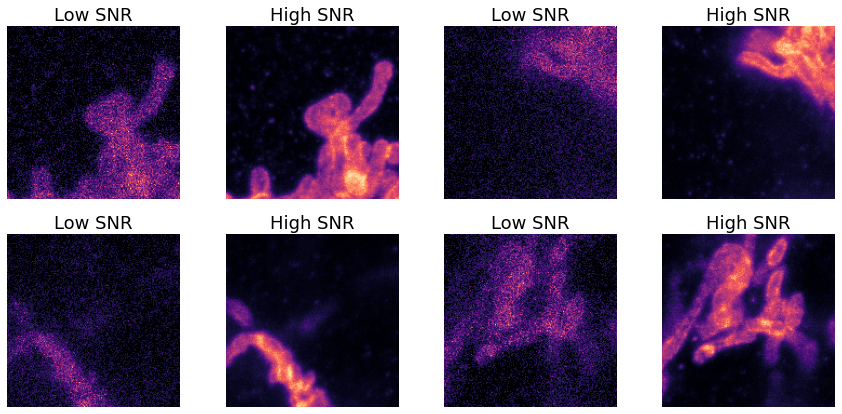

In [3]:
mip_x_train=np.max(x_train,axis=3)
mip_y_train=np.max(y_train,axis=3)

ix = random.sample(range(len(x_train)),4)
fig = plt.figure(figsize=(15,7))

for i in range(4):
    fig.add_subplot(2,4, 2*i+1)
    cmap=plt.get_cmap('magma')
    plt.imshow(mip_x_train[ix[i],:,:,0].squeeze(),cmap)
    plt.title('Low SNR',fontdict={'fontsize':18})
    plt_axis = plt.axis('off')

    fig.add_subplot(2,4, 2*i+2)
    cmap=plt.get_cmap('magma')
    plt.imshow(mip_y_train[ix[i],:,:,0].squeeze(),cmap)
    plt.title('High SNR',fontdict={'fontsize':18})
    plt_axis = plt.axis('off')

In [4]:
model_save_directory = r"D:\Projects\Denosing-STED-Abberior\2022-11-03_UCF_DemoSamples\3D STED_TOM20\patches\unet_rcan_microtubule.h5" 
load_model_save_directory = r"D:\Models\Data generator\ddx39b-son\ddx39B-file_4.h5" 


n_epochs =  200
gen_lr = 1e-4

filters =[32,64,128]
num_filters = filters[0]
filters_cab=num_filters/16
num_RG=3
num_RCAB=8

generator_input = Input((patch_size, patch_size,frame_end-frame_start,1))
generator = make_generator(generator_input, filters, num_filters,filters_cab,num_RG,num_RCAB,
                           kernel_shape=3,dropout=0.2)
gen_opt = keras.optimizers.Adam(learning_rate=gen_lr)
generator.compile(optimizer=gen_opt, loss=generator_loss)
# generator.load_weights(load_model_save_directory)



def scheduler(epoch, lr):
    if np.mod(epoch+1,20)==0:
        return lr*0.8
    else:
        return lr

callbacks = [
    EarlyStopping(patience=100, verbose=1),
    LearningRateScheduler(scheduler),
    ModelCheckpoint(filepath=model_save_directory, verbose=1, save_best_only=True, save_weights_only=True)]

In [5]:
results = generator.fit(x=x_train,y=y_train, batch_size=batch_size, epochs=n_epochs,verbose=1,
                        callbacks=callbacks,validation_split=0.1)

Epoch 1/200
878/878 [==============================] - ETA: 0s - loss: 0.2457 - conv3d_33_loss: 0.1093 - conv3d_135_loss: 0.1364
Epoch 00001: val_loss improved from inf to 0.19871, saving model to D:\Projects\Denosing-STED-Abberior\2022-11-03_UCF_DemoSamples\3D STED_TOM20\patches\unet_rcan_microtubule.h5
878/878 [==============================] - 532s 593ms/step - loss: 0.2457 - conv3d_33_loss: 0.1093 - conv3d_135_loss: 0.1364 - val_loss: 0.1987 - val_conv3d_33_loss: 0.0982 - val_conv3d_135_loss: 0.1005 - lr: 1.0000e-04
Epoch 2/200
878/878 [==============================] - ETA: 0s - loss: 0.2008 - conv3d_33_loss: 0.0997 - conv3d_135_loss: 0.1011
Epoch 00002: val_loss improved from 0.19871 to 0.19613, saving model to D:\Projects\Denosing-STED-Abberior\2022-11-03_UCF_DemoSamples\3D STED_TOM20\patches\unet_rcan_microtubule.h5
878/878 [==============================] - 521s 593ms/step - loss: 0.2008 - conv3d_33_loss: 0.0997 - conv3d_135_loss: 0.1011 - val_loss: 0.1961 - val_conv3d_33_loss

Epoch 18/200
878/878 [==============================] - ETA: 0s - loss: 0.1879 - conv3d_33_loss: 0.0940 - conv3d_135_loss: 0.0939
Epoch 00018: val_loss improved from 0.18721 to 0.18718, saving model to D:\Projects\Denosing-STED-Abberior\2022-11-03_UCF_DemoSamples\3D STED_TOM20\patches\unet_rcan_microtubule.h5
878/878 [==============================] - 520s 593ms/step - loss: 0.1879 - conv3d_33_loss: 0.0940 - conv3d_135_loss: 0.0939 - val_loss: 0.1872 - val_conv3d_33_loss: 0.0937 - val_conv3d_135_loss: 0.0935 - lr: 1.0000e-04
Epoch 19/200
878/878 [==============================] - ETA: 0s - loss: 0.1873 - conv3d_33_loss: 0.0937 - conv3d_135_loss: 0.0936
Epoch 00019: val_loss did not improve from 0.18718
878/878 [==============================] - 520s 593ms/step - loss: 0.1873 - conv3d_33_loss: 0.0937 - conv3d_135_loss: 0.0936 - val_loss: 0.1876 - val_conv3d_33_loss: 0.0939 - val_conv3d_135_loss: 0.0937 - lr: 1.0000e-04
Epoch 20/200
878/878 [==============================] - ETA: 0s - lo

878/878 [==============================] - ETA: 0s - loss: 0.1804 - conv3d_33_loss: 0.0903 - conv3d_135_loss: 0.0901
Epoch 00038: val_loss did not improve from 0.18718
878/878 [==============================] - 520s 592ms/step - loss: 0.1804 - conv3d_33_loss: 0.0903 - conv3d_135_loss: 0.0901 - val_loss: 0.1899 - val_conv3d_33_loss: 0.0952 - val_conv3d_135_loss: 0.0946 - lr: 8.0000e-05
Epoch 39/200
878/878 [==============================] - ETA: 0s - loss: 0.1801 - conv3d_33_loss: 0.0901 - conv3d_135_loss: 0.0900
Epoch 00039: val_loss did not improve from 0.18718
878/878 [==============================] - 520s 592ms/step - loss: 0.1801 - conv3d_33_loss: 0.0901 - conv3d_135_loss: 0.0900 - val_loss: 0.1896 - val_conv3d_33_loss: 0.0949 - val_conv3d_135_loss: 0.0948 - lr: 8.0000e-05
Epoch 40/200
878/878 [==============================] - ETA: 0s - loss: 0.1792 - conv3d_33_loss: 0.0897 - conv3d_135_loss: 0.0895
Epoch 00040: val_loss did not improve from 0.18718
878/878 [=====================

Epoch 59/200
878/878 [==============================] - ETA: 0s - loss: 0.1757 - conv3d_33_loss: 0.0880 - conv3d_135_loss: 0.0878
Epoch 00059: val_loss did not improve from 0.18718
878/878 [==============================] - 520s 593ms/step - loss: 0.1757 - conv3d_33_loss: 0.0880 - conv3d_135_loss: 0.0878 - val_loss: 0.1904 - val_conv3d_33_loss: 0.0953 - val_conv3d_135_loss: 0.0951 - lr: 6.4000e-05
Epoch 60/200
878/878 [==============================] - ETA: 0s - loss: 0.1751 - conv3d_33_loss: 0.0877 - conv3d_135_loss: 0.0874
Epoch 00060: val_loss did not improve from 0.18718
878/878 [==============================] - 521s 593ms/step - loss: 0.1751 - conv3d_33_loss: 0.0877 - conv3d_135_loss: 0.0874 - val_loss: 0.1912 - val_conv3d_33_loss: 0.0957 - val_conv3d_135_loss: 0.0955 - lr: 5.1200e-05
Epoch 61/200
878/878 [==============================] - ETA: 0s - loss: 0.1750 - conv3d_33_loss: 0.0876 - conv3d_135_loss: 0.0874
Epoch 00061: val_loss did not improve from 0.18718
878/878 [========

Epoch 80/200
878/878 [==============================] - ETA: 0s - loss: 0.1726 - conv3d_33_loss: 0.0864 - conv3d_135_loss: 0.0862
Epoch 00080: val_loss did not improve from 0.18718
878/878 [==============================] - 520s 593ms/step - loss: 0.1726 - conv3d_33_loss: 0.0864 - conv3d_135_loss: 0.0862 - val_loss: 0.1916 - val_conv3d_33_loss: 0.0958 - val_conv3d_135_loss: 0.0958 - lr: 4.0960e-05
Epoch 81/200
878/878 [==============================] - ETA: 0s - loss: 0.1725 - conv3d_33_loss: 0.0864 - conv3d_135_loss: 0.0861
Epoch 00081: val_loss did not improve from 0.18718
878/878 [==============================] - 520s 593ms/step - loss: 0.1725 - conv3d_33_loss: 0.0864 - conv3d_135_loss: 0.0861 - val_loss: 0.1915 - val_conv3d_33_loss: 0.0958 - val_conv3d_135_loss: 0.0957 - lr: 4.0960e-05
Epoch 82/200
878/878 [==============================] - ETA: 0s - loss: 0.1724 - conv3d_33_loss: 0.0864 - conv3d_135_loss: 0.0861
Epoch 00082: val_loss did not improve from 0.18718
878/878 [========

Epoch 101/200
878/878 [==============================] - ETA: 0s - loss: 0.1708 - conv3d_33_loss: 0.0856 - conv3d_135_loss: 0.0853
Epoch 00101: val_loss did not improve from 0.18718
878/878 [==============================] - 520s 593ms/step - loss: 0.1708 - conv3d_33_loss: 0.0856 - conv3d_135_loss: 0.0853 - val_loss: 0.1920 - val_conv3d_33_loss: 0.0961 - val_conv3d_135_loss: 0.0959 - lr: 3.2768e-05
Epoch 102/200
878/878 [==============================] - ETA: 0s - loss: 0.1707 - conv3d_33_loss: 0.0855 - conv3d_135_loss: 0.0852
Epoch 00102: val_loss did not improve from 0.18718
878/878 [==============================] - 521s 593ms/step - loss: 0.1707 - conv3d_33_loss: 0.0855 - conv3d_135_loss: 0.0852 - val_loss: 0.1922 - val_conv3d_33_loss: 0.0962 - val_conv3d_135_loss: 0.0960 - lr: 3.2768e-05
Epoch 103/200
878/878 [==============================] - ETA: 0s - loss: 0.1707 - conv3d_33_loss: 0.0855 - conv3d_135_loss: 0.0852
Epoch 00103: val_loss did not improve from 0.18718
878/878 [=====